# IRT Solver with L2 Loss - Iterative Refinement - Simulated Data
We assume that each item measures a single scale.

To test our non-parametric IRT model, we generate $20$ items with a parameteric form and sample $200$ student abilities from the prior distribution (normal) assumed in IRT literature. We then use our solver (IRF refinement outer loop for continuation; iterations of updating IRFs using a histogram and MLE estimation of $\theta$ for each IRF resolution).

The process converges to a stationary point, but the resulting IRFs are not smooth.

In [1]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import cntree.cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.run_recorder
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import nirt.solver_item_clustering
import nirt.solver_refinement
import numpy as np
import numpy.matlib
import sklearn.metrics
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(2)

np.set_printoptions(precision=3, linewidth=1000)

In [87]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

# Type of loss function.
loss = "l2"

## Generate Synthetic Data

In [3]:
# Algorithm parameters.
num_bins = 8
num_iterations = 10
num_theta_sweeps = 5
# Initial simulated annealing temperature.
temperature = 1
# IRF binning strategy.
grid_method = "quantile" # "uniform-fixed" # "quantile" # "uniform" 

In [4]:
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination)
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)
print("mean", np.mean(theta_exact, axis=0))
print("std", np.std(theta_exact, axis=0))

mean [-0.048]
std [1.004]


(1000, 1)


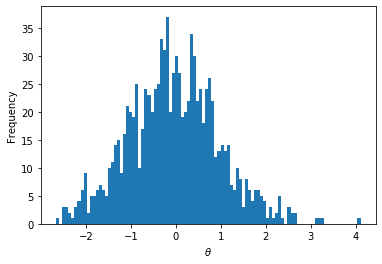

In [5]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta_exact.shape)
plt.hist(theta_exact[:, 0], 100)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

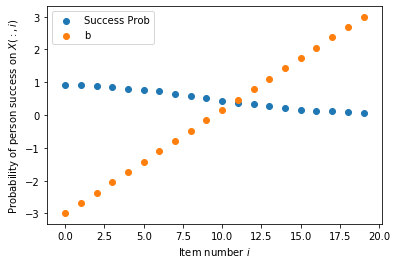

In [6]:
plt.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
plt.scatter(range(I), b, label="b")
plt.xlabel("Item number $i$")
plt.ylabel("Probability of person success on $X(:,i)$")
plt.legend();

# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

# Experiment: Start from the Exact Solution and see if we can reproduce it

In [7]:
theta = nirt.likelihood.initial_guess(X, c)
theta = (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)
theta_init = theta

In [8]:
theta = theta_exact
theta = (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)

In [9]:
print("mean", np.mean(theta, axis=0))
print("std", np.std(theta, axis=0))

mean [-1.776e-17]
std [1.]


## Initial IRFs

In [10]:
# For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
# quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
inactive = np.arange(P, dtype=int)
active = np.array([], dtype=int)

xlim = [(min(theta[:, ci])-1, max(theta[:, ci])+1) for ci in range(C)]
grid_all = [nirt.grid.create_grid(theta[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]
irf_all = [nirt.irf.ItemResponseFunction(grid_all[ci], X[:, i]) for i, ci in enumerate(c)]
print("Grid limits", xlim)

Grid limits [(-3.6002314549892844, 5.138449489758167)]


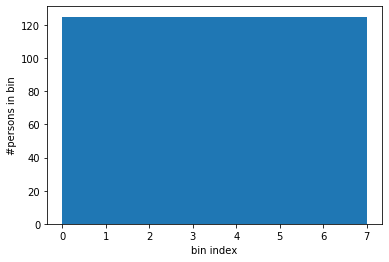

In [11]:
# Print the distribution of bin sizes. Should be uniform since it's a quantile grid.
plt.hist(grid_all[0].bin_index, num_bins)
plt.xlabel('bin index')
plt.ylabel('#persons in bin');

In [12]:
# Generate histogram IRFs from a sample of persons.
initial_sample_per_bin = 10
sample_size = initial_sample_per_bin * num_bins
sample = np.random.choice(inactive, size=sample_size, replace=False)
#sample = np.arange(P, dtype=int)
active = np.concatenate((active, sample))
theta_active = theta[sample]

# Index arrays for converting theta[active] into flattened form and back.
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)

In [13]:
grid = [nirt.grid.create_grid(theta_active[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]
irf = np.array([nirt.irf.ItemResponseFunction(grid[ci], X[sample, i]) for i, ci in enumerate(c)])
e_all = nirt.error.error_norm_by_item(model_irf, irf_all)
e = nirt.error.error_norm_by_item(model_irf, irf)
print("IRF error of the {} items".format(I))
print("All samples: {:.3f} +- {:.3f}".format(e_all.mean(), e_all.std()))
print("{} samples: {:.3f} +- {:.3f}".format(sample_size, e.mean(), e.std()))

IRF error of the 20 items
All samples: 0.056 +- 0.023
80 samples: 0.115 +- 0.030


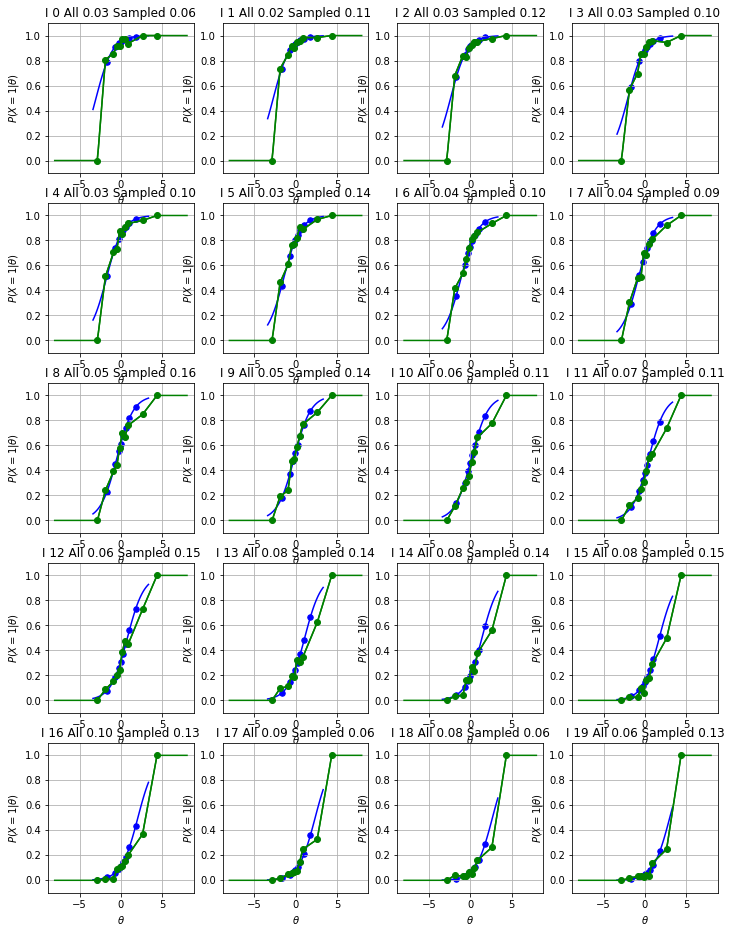

In [14]:
fig, axs = plt.subplots(I // 4, 4, figsize=(12, 0.8*I))
for i in range(I):
    ax = axs[i // 4, i % 4]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], color="blue", label="Original")
    irf_all[i].plot(ax, color="green", label="{} samples".format(theta.shape[0]))
    #irf[i].plot(ax, color="red", label="{} samples".format(sample_size))
    ax.set_title("I {} All {:.2f} Sampled {:.2f}".format(i, e_all[i], e[i]))
    ax.grid(True)

Although $P_i(\theta)$ is generally monotonically increasing, there are already kinks. Maybe this is stochastic (sampling) noise, as $P=500$ persons is not very large. See for example the IRF of item $i = 8$:

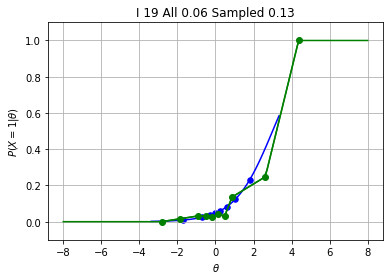

In [15]:
fig, ax = plt.subplots(1, 1)
nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], color="blue", label="Original")
irf_all[i].plot(ax, color="green", label="{} samples".format(theta.shape[0]))
#irf[i].plot(ax, color="red", label="{} samples".format(sample_size))
ax.set_title("I {} All {:.2f} Sampled {:.2f}".format(i, e_all[i], e[i]))
ax.grid(True)

So, even at this stage we get kinks

## Iterative IRF Refinement Solver

We start from a coarse IRF resolution. At each resolution, we iterate between updating the IRF as a histogram and updating $\theta$ via MSE Loss.
* MSE loss is much faster to minimize than MLE, especially for piecewise constant IRF interpolant.

We see convergence only if $\theta$ is normalized to $0$ mean and unit standard deviation.

In [16]:
active = np.arange(P, dtype=int)
sample = active
theta_active = theta[sample]
print("mean", np.mean(theta[active], axis=0), "std", np.std(theta[active], axis=0))

mean [-1.776e-17] std [1.]


In [88]:
# Run iterative refinement algorithm.
# v is fixed.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_refinement.SolverRefinement(
    X, c, num_iterations=4, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder, finest_resolution=16, coarsest_resolution=4,
    theta_init=theta_exact, loss=loss)

t = solver.solve()

INFO     Initial guess range [-3.01, 2.80] mean 0.00 std 1.00
INFO     Solving at IRF resolution 4
INFO     Iteration 1/4


KeyboardInterrupt: 

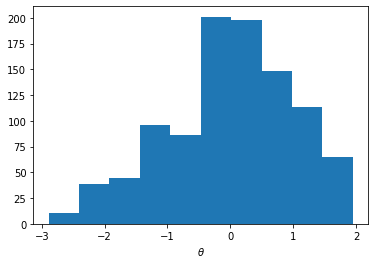

In [18]:
plt.hist(recorder.theta[16][1]);
plt.xlabel(r"$\theta$");

In [19]:
# Run history: calculate the IRF error from the known parametric model.

for resolution, value in recorder.irf.items():
    logger.info("IRF resolution {}".format(resolution))
    for j in range(len(value)):
        e = nirt.error.error_norm_by_item(model_irf, value[j])
        t = recorder.theta[resolution][j]
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.2f}, {:.2f}".format(
            e.mean(), e.std(), t.min(), t.max()))

INFO     IRF resolution 4
INFO     IRF error: 0.042 +- 0.012	t range -2.56, 2.25
INFO     IRF error: 0.043 +- 0.026	t range -2.48, 2.17
INFO     IRF error: 0.054 +- 0.038	t range -2.41, 2.13
INFO     IRF error: 0.061 +- 0.044	t range -2.37, 2.11
INFO     IRF resolution 8
INFO     IRF error: 0.073 +- 0.050	t range -2.41, 2.06
INFO     IRF error: 0.092 +- 0.057	t range -2.54, 2.05
INFO     IRF error: 0.102 +- 0.061	t range -2.61, 2.02
INFO     IRF error: 0.106 +- 0.063	t range -2.71, 1.99
INFO     IRF resolution 16
INFO     IRF error: 0.127 +- 0.071	t range -2.77, 1.98
INFO     IRF error: 0.139 +- 0.078	t range -2.89, 1.95
INFO     IRF error: 0.145 +- 0.083	t range -2.96, 1.93
INFO     IRF error: 0.147 +- 0.085	t range -3.03, 1.91


[4, 8, 16]


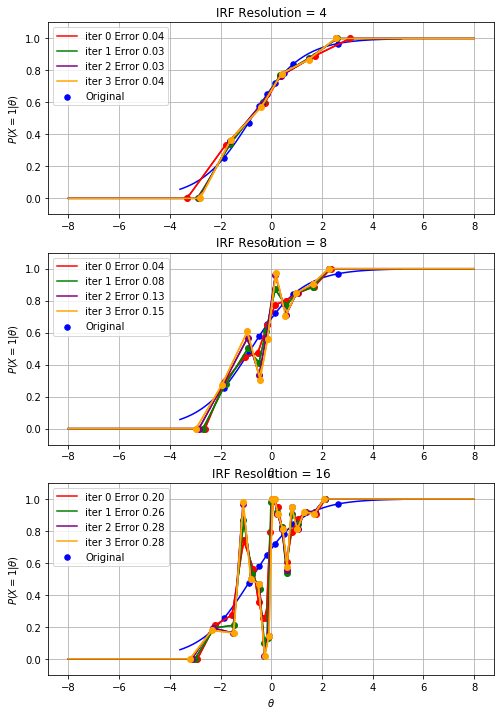

In [20]:
i = 7
resolutions = list(recorder.irf.keys())
print(resolutions)
fig, axs = plt.subplots(len(resolutions), 1, figsize=(8, 4*len(resolutions)))
for k, resolution in enumerate(resolutions):
    ax = axs[k] if len(resolutions) > 1 else axs
    colors = ["red", "green", "purple", "orange"]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid_all[c[i]], model_irf[i], color="blue", label="Original")
    for l, irf in enumerate(recorder.irf[resolution]):
        irf[i].plot(ax, color=colors[l % len(colors)],
                    label="iter {} Error {:.2f}".format(
                        l, nirt.error.error_norm(model_irf[i], irf[i])))
    ax.set_title("IRF Resolution = {}".format(resolution))
    ax.grid(True)
    ax.legend()

Even though the initial guess is not bad (6% error), the IRF develops more kinks after th iteration. It is possible that both the histogram building and the MLE estimate for $\theta$ are causing this: the histogram, as we've seen, has sampling noise; then the MLE has $O(1/\sqrt{I})$ error, where $I$ is the number of items. It might cause $\theta_p$'s to switch bins.

## Item Clustering
The idea here is to start with a small number of item clusters and gradually refine them to obtain a good initial guess for the original (all-item) problem.

### Distance Metric
Since item vectors are long (of size $P$), clustering in their space is problematic. Instead, we first create shorter items vectors, whose entries correspond to the success of student percentiles of size $L$ on the item instead of individual students:

$$ v_i := \left(v_{i1},\dots,v_{iM}\right)^T\,,\qquad M = [P/L], $$

$$ v_{im} := \frac{1}{|S_m|} \sum_{p \in S_m} x_{im}\,,\qquad m = 1,\dots,M. $$

The distance measure between items $i,i'$ is $d(i,i') := \|v_i-v_{i'}\|_2$. We study the dependence of the *strong* correlations on $L$.

Looks like allowing $L = [P/50]$, i.e., $L = O(P)$ that gives a sufficiently fine resolution in the IRF, gives th same neighbors as $L = 1$.

In [21]:
L_values = 2 ** np.arange(5)
xl = {}
d = {}
for L in L_values:
    xl[L] = X[nirt.irf.sorted_chunks(X, L)].mean(1)
    print(L, xl[L].shape)
    #d[L] = np.abs(np.corrcoef(xl[L].transpose()))
    d[L] = sklearn.metrics.euclidean_distances(xl[L].transpose())

1 (1000, 20)
2 (500, 20)
4 (250, 20)
8 (125, 20)
16 (62, 20)


(50, 20)


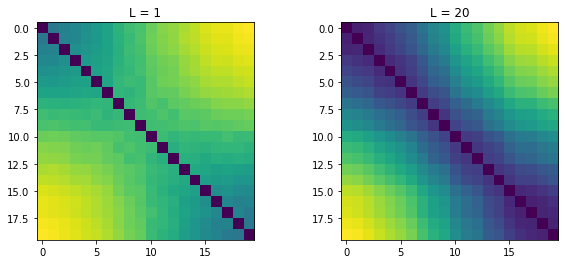

In [24]:
L = P // 50
x_coarse = X[nirt.irf.sorted_chunks(X, L)].mean(1)
print(x_coarse.shape)
d_coarse = sklearn.metrics.euclidean_distances(x_coarse.transpose())

# Compare L = 1 (individual student) distances with L = [P/50], i.e., resolution of size 50 in IRF for distances.
# Scale doesn't matter much, just the qualitative behavior of distances.
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
vmax = max(d[1].max(), d_coarse.max())
           
ax = axs[0]
ax.imshow(d[1], vmin=0) #, vmax=vmax);
ax.set_title("L = 1")


ax = axs[1]
im = ax.imshow(d_coarse, vmin=0) #, vmax=vmax);
ax.set_title("L = {}".format(L));

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)

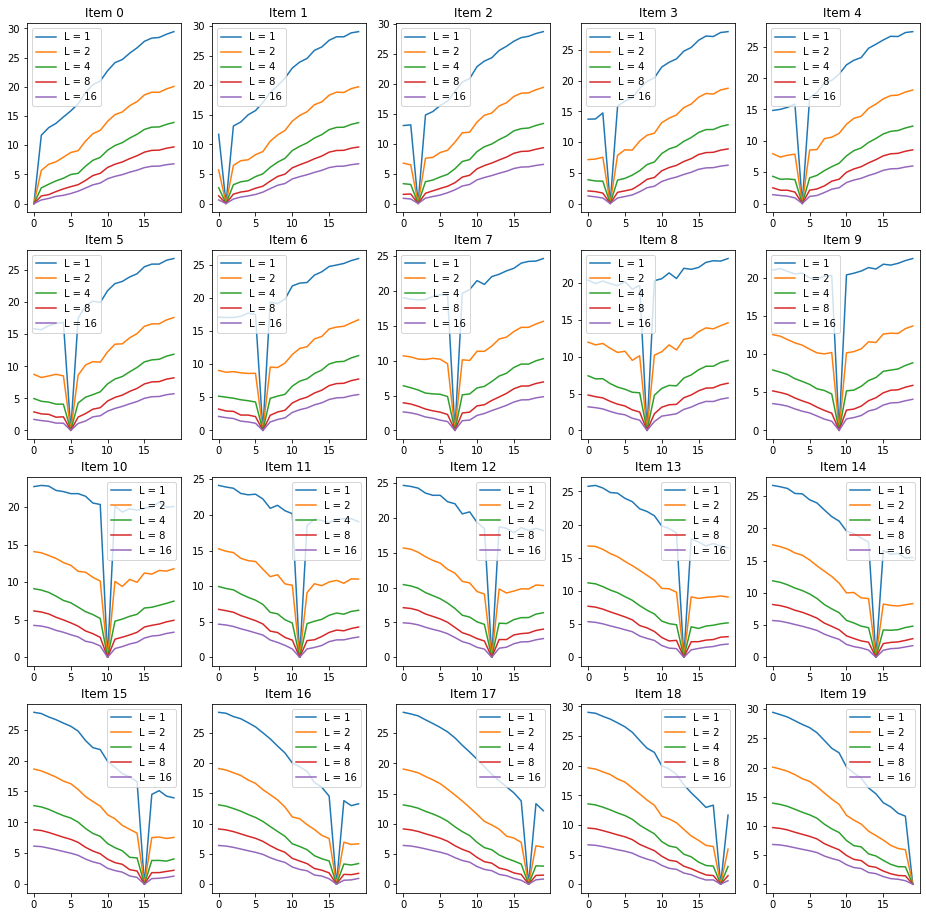

In [25]:
fig, axs = plt.subplots(I // 5, 5, figsize=(16, 0.8*I))
for i in range(I):
    ax = axs[i // 5, i % 5]
    for l in L_values:
        ax.plot(d[l][i], label="L = {}".format(l))
    ax.set_title("Item {}".format(i))
    ax.legend();

### Item Mini-clustering
Using the coarser/shorter vectors with $L = [P/50]$.

In [26]:
tree = cntree.cntree.CNTree(debug=1)
clustering = tree.cluster(x_coarse.transpose())

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.7    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.01
INFO     5    	7    	20   	1.00   	1.0    	0.0    	0.01
INFO     Total						0.02
INFO     Trimming #neighbors to 5


In [27]:
for level in [level for level in cntree.cntree.get_clustering_levels(clustering) if level.size <= 0.5 * I]:
    print(level, level.label)

Level 0[size=1,num_neighbors=1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Level 1[size=2,num_neighbors=2] [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Level 2[size=4,num_neighbors=4] [2 2 2 2 2 2 3 3 3 3 1 1 1 1 0 0 0 0 0 0]
Level 3[size=8,num_neighbors=7] [5 5 5 4 4 4 6 6 7 7 3 3 2 2 0 0 1 1 1 1]


## Iterative Item Clustering + IRF Resolution Refinement Solver
Refining the item cluster resolution and the IRFs at the same time during continuation steps.

In [143]:
# Run iterative refinement algorithm.
# v is fixed.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=3, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder, finest_resolution=16, coarsest_resolution=4,
    theta_init=theta_exact, loss=loss)

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.7    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	20   	1.00   	1.0    	0.0    	0.00
INFO     Total						0.02
INFO     Trimming #neighbors to 5


In [144]:
t = solver.solve()

INFO     Initial guess range [-3.01, 2.80] mean 0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 2 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 4 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 8 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3
INFO     Solving at item clustering level with 20 items 4 bins
INFO     Iteration 1/3
INFO     Iteration 2/3
INFO     Iteration 3/3


In [159]:
# Run history: calculate the IRF error from the known parametric model.
for k, (resolution, value) in enumerate(recorder.irf.items()):
    logger.info("#items {}".format(resolution))
    level = solver._clustering[k]
    cluster_model_irf = [
        lambda t, i=i: np.array([model_irf[j](t) for j in level[i]]).mean(0) 
        for i in range(resolution)]
    for j in range(len(value)):
        e = nirt.error.error_norm_by_item(cluster_model_irf, value[j])
        t = recorder.theta[resolution][j]
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.3f}, {:.3f} corr {:.2f}".format(
            e.mean(), e.std(), t.min(), t.max(), np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1]))

INFO     #items 1
INFO     IRF error: 0.029 +- 0.000	t range -2.390, 1.958 corr 0.78
INFO     IRF error: 0.016 +- 0.000	t range -2.571, 2.313 corr 0.84
INFO     IRF error: 0.016 +- 0.000	t range -2.579, 2.241 corr 0.84
INFO     #items 2
INFO     IRF error: 0.020 +- 0.008	t range -2.620, 2.144 corr 0.83
INFO     IRF error: 0.034 +- 0.019	t range -2.588, 2.076 corr 0.82
INFO     IRF error: 0.037 +- 0.018	t range -2.578, 2.096 corr 0.82
INFO     #items 4
INFO     IRF error: 0.042 +- 0.027	t range -2.607, 2.084 corr 0.80
INFO     IRF error: 0.057 +- 0.025	t range -2.473, 2.019 corr 0.78
INFO     IRF error: 0.057 +- 0.029	t range -2.447, 1.989 corr 0.78
INFO     #items 8
INFO     IRF error: 0.059 +- 0.032	t range -2.449, 2.003 corr 0.78
INFO     IRF error: 0.061 +- 0.033	t range -2.457, 2.018 corr 0.78
INFO     IRF error: 0.066 +- 0.035	t range -2.445, 2.021 corr 0.78
INFO     #items 20
INFO     IRF error: 0.065 +- 0.042	t range -2.416, 1.970 corr 0.79
INFO     IRF error: 0.066 +- 0.045	t r

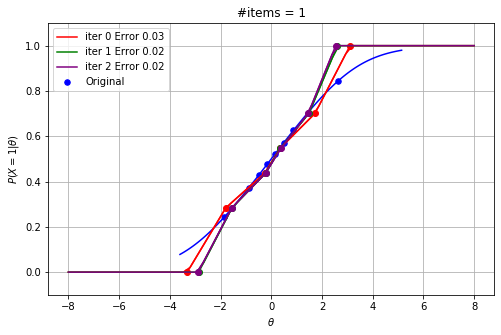

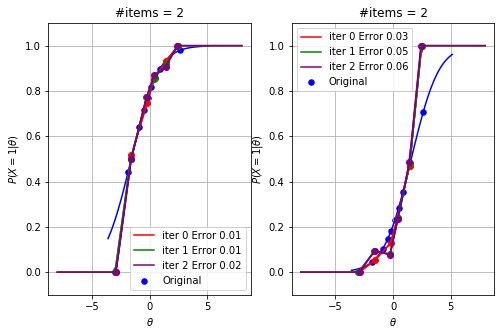

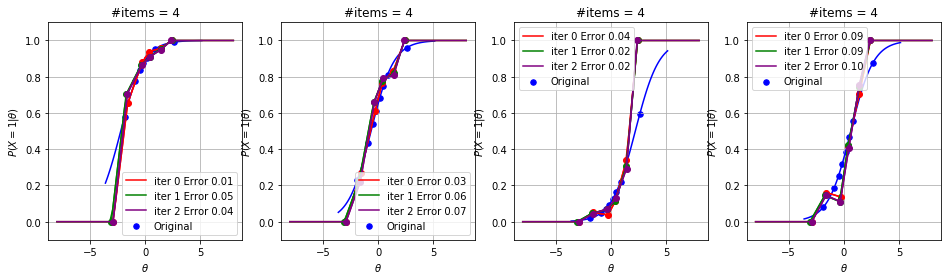

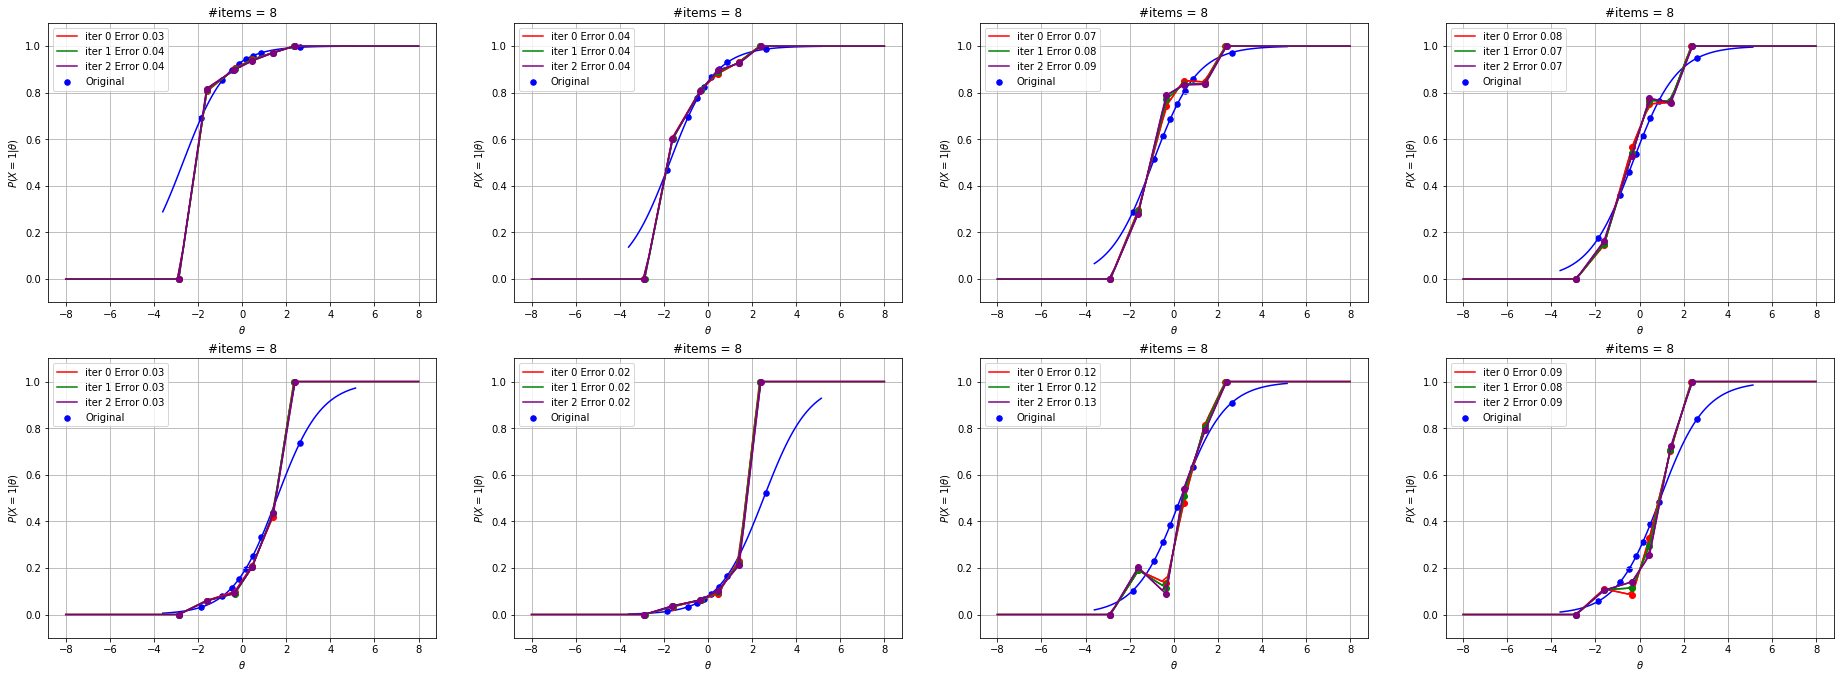

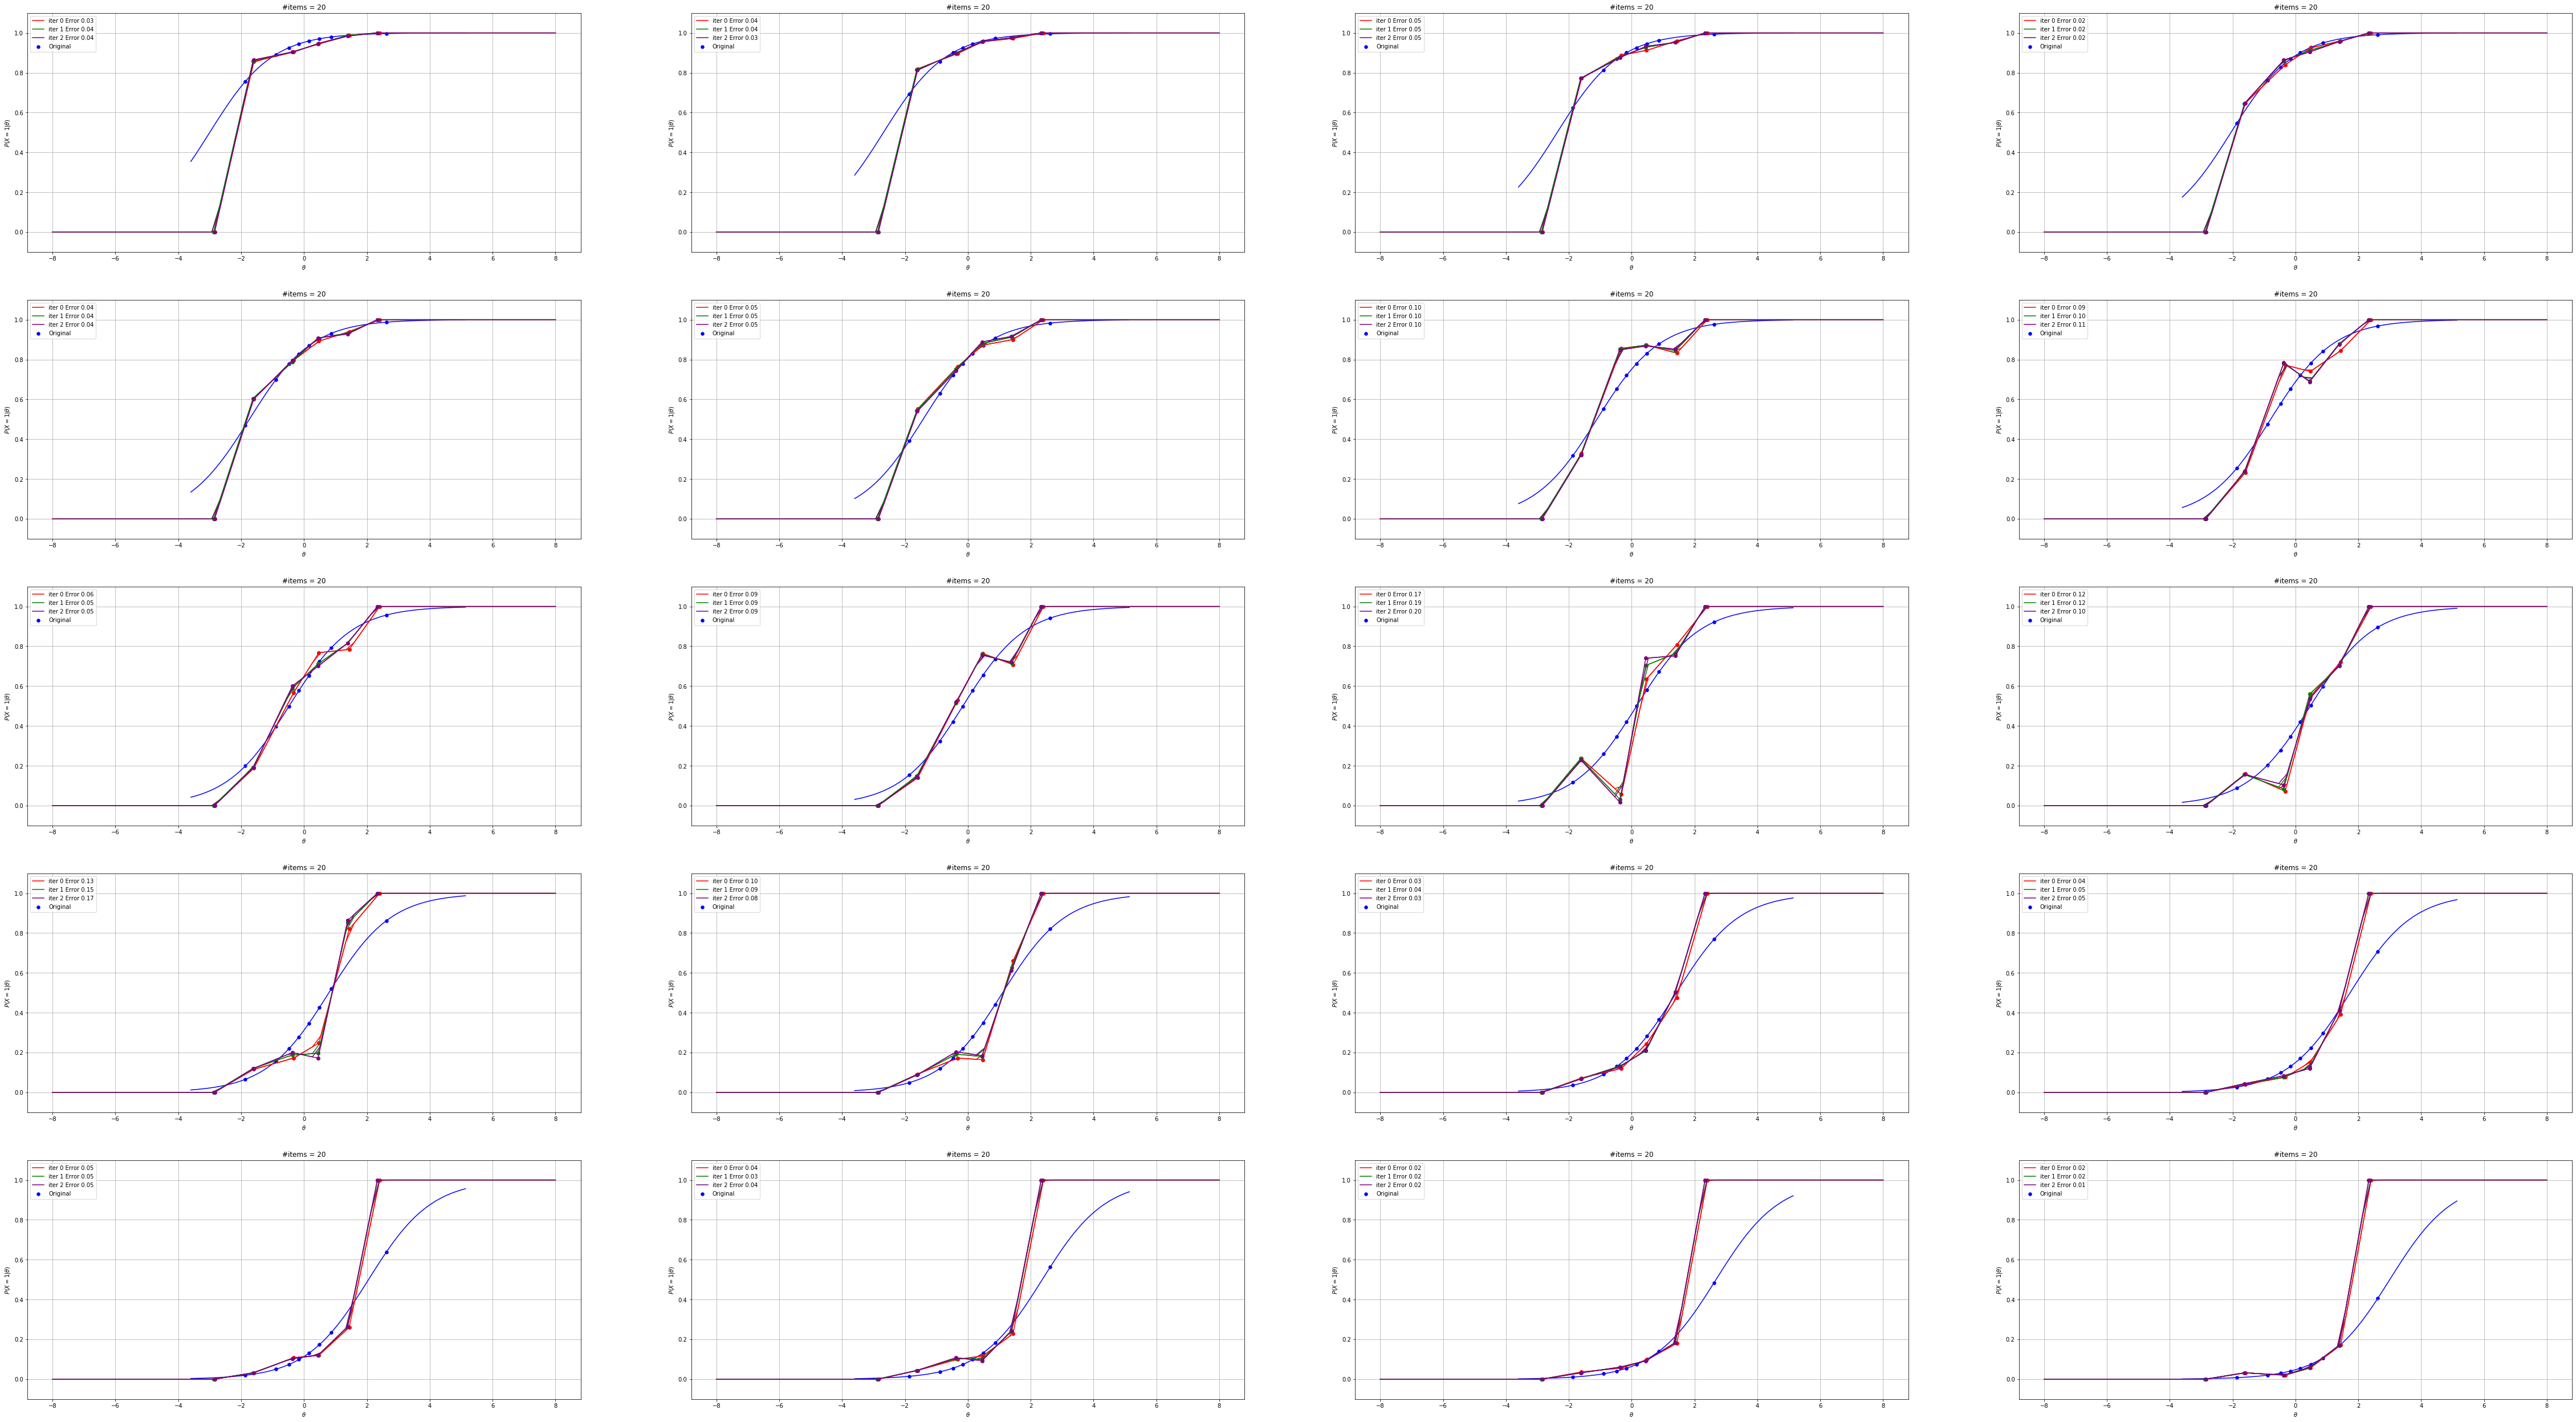

In [146]:
i = 0
item_levels = list(recorder.irf.keys())
#print("#items", item_levels)

for k, num_items in enumerate(item_levels):
    if num_items < 4:
        fig, axs = plt.subplots(1, num_items, figsize=(8, 5))
    else:
        fig, axs = plt.subplots(num_items // 4, 4, figsize=(4 * num_items, 0.5 * num_items ** 1.5))
    cluster = solver._clustering[k]
    
    for i in range(num_items):
        ax = axs[i // 4, i % 4] if num_items > 4 else (axs[i] if num_items > 1 else axs)
        colors = ["red", "green", "purple", "orange"]
        cluster_model_irf = lambda t: np.array([model_irf[j](t) for j in cluster[i]]).mean(0)
        nirt.simulate.plot_irf.plot_model_irf(
            ax, grid_all[c[i]], cluster_model_irf, color="blue", label="Original")
        for l, irf in enumerate(recorder.irf[num_items]):
            irf[i].plot(ax, color=colors[l % len(colors)],
                        label="iter {} Error {:.2f}".format(
                            l, nirt.error.error_norm(cluster_model_irf, irf[i])))
        ax.set_title("#items = {}".format(num_items))
        ax.grid(True)
        ax.legend()

The correlation between the exact $\theta$ and $\hat{\theta}$ stays $\approx 0.8$ throughout the refinement levels, even though the IRFs have more kinks as the resolution is refined. 

So there are multiple IRFs that result in the same $\theta$. Is there a way to regularize it?

In [147]:
np.corrcoef(X.mean(1), theta_exact[:, 0])[0, 1]

0.8502578282051537

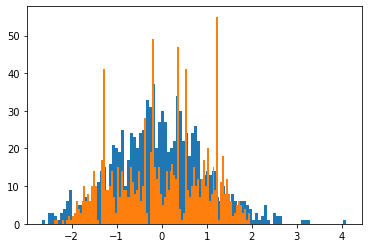

In [148]:
plt.hist(theta_exact, 100);
plt.hist(t[:, 0], 100);

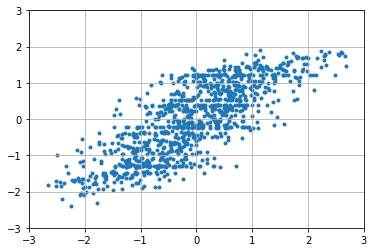

In [149]:
plt.scatter(theta_exact[:, 0], t[:, 0], marker='.');
plt.xlim([-3, 3]);
plt.ylim([-3, 3]);
plt.grid(True);

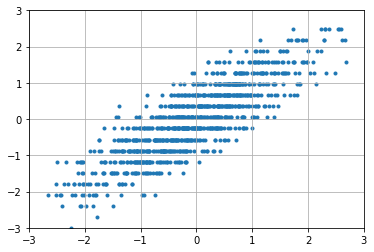

In [150]:
theta_score = X.mean(1)
theta_score = (theta_score - np.mean(theta_score, axis=0)) / np.std(theta_score, axis=0);

plt.scatter(theta_exact[:, 0], theta_score, marker='.');
plt.xlim([-3, 3]);
plt.ylim([-3, 3]);
plt.grid(True);

In [151]:
import collections

score = collections.Counter([tuple(t) for t in X])

In [152]:
collections.Counter(score.values())

Counter({1: 721, 3: 22, 4: 6, 2: 82, 5: 5})

In [153]:
irf = recorder.irf[20][2]

In [154]:
p = 0
print(p, theta_exact[p], t[p])
xp = X[p]

mse_loss = lambda t: sum((irf[i].interpolant(t) - xp[i]) ** 2 for i in range(len(irf)))

0 [-0.417] [-0.084]


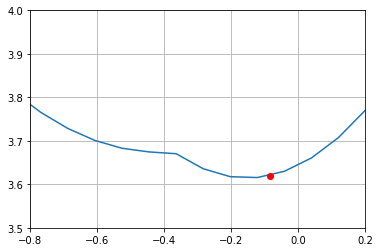

In [155]:
t_continuous = np.linspace(-4, 4, 100)

plt.plot(t_continuous, mse_loss(t_continuous));
plt.grid(True);
plt.xlim([-0.8, 0.2]);
plt.ylim([3.5, 4]);

plt.plot([t[p]], [mse_loss(t[p])], 'ro');

In [156]:
theta_improver = nirt.theta_improvement.theta_improver_factory(
            solver._improve_theta_method, solver._num_theta_sweeps, loss=solver._loss)
likelihood = nirt.likelihood.Likelihood(X, solver.c, solver.irf)

In [157]:
active = np.arange(P, dtype=int)
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)
theta_active = theta_improver.run(likelihood, theta_active, active_ind)
print(theta_active[p])
theta_active = (theta_active - np.mean(theta_active, axis=0)) / np.std(theta_active, axis=0)
print(theta_active[p])

[-0.152]
[-0.084]


In [158]:
[recorder.theta[20][k][p] for k in range(len(recorder.theta[20]))]

[array([0.09]), array([-0.014]), array([-0.084])]